# Prediction of the area under the curve (AUC) of the drug release profile with XGBoost (XGB)
## Initialization of environment

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from optuna.samplers import TPESampler
import warnings
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore")

## Data loading and preparation¶
Definition of variables, data loading, normalization and interpolation of the drug release profile, calculation of drug release profile AUC

In [7]:
num_interp_pts = 11
n_outer_folds = 10
n_inner_folds = 2
n_trials = 50
# ----------------------------------------------------------------------------------------
# Load data
# ----------------------------------------------------------------------------------------
file_path_form = 'mp_dataset_processed_no_dupes.xlsx'
file_path_time = 'mp_dataset_processed_time_release_only.xlsx'
formulation_df = pd.read_excel(file_path_form, engine='openpyxl')
release_df = pd.read_excel(file_path_time, engine='openpyxl')

# ----------------------------------------------------------------------------------------
# Encode categorical formulation variable
# ----------------------------------------------------------------------------------------
unique_values_emulsion = formulation_df['Formulation Method'].unique()
mapping = {v: i for i, v in enumerate(unique_values_emulsion)}
formulation_df['Formulation Method Encoded'] = formulation_df['Formulation Method'].map(mapping)
formulation_df.drop(columns=['Formulation Method', 'Drug SMILES'], inplace=True)


# ----------------------------------------------------------------------------------------
# Normalization and interpolation
# ----------------------------------------------------------------------------------------
group = release_df.groupby('Formulation Index')['Time']
min_time = group.transform('min')
max_time = group.transform('max')
release_df['Normalized Time'] = (release_df['Time'] - min_time) / (max_time - min_time)
normalized_times = np.linspace(0, 1, num_interp_pts)
interpolated_dfs = []
for formulation, g in release_df.groupby('Formulation Index'):
    g = g.sort_values('Time')
    time_min, time_max = g['Time'].min(), g['Time'].max()
    g['Normalized Time'] = (g['Time'] - time_min) / (time_max - time_min)
    interp_release = np.interp(normalized_times, g['Normalized Time'], g['Release'])
    interpolated_dfs.append(pd.DataFrame({
        'Formulation Index': formulation,
        'Normalized Time': normalized_times,
        'Interpolated Release': interp_release
    }))
interp_df = pd.concat(interpolated_dfs, ignore_index=True)

X = formulation_df.drop(columns=['Formulation Index']).to_numpy()
groups = interp_df.groupby('Formulation Index')['Interpolated Release']
y = np.stack([g.to_numpy().reshape(-1, 1) for _, g in groups]) # [321, 11, 1]

# ----------------------------------------------------------------------------------------
# AUC
# ----------------------------------------------------------------------------------------
auc = (
    interp_df.groupby("Formulation Index")
      .apply(lambda g: np.trapz(g["Interpolated Release"], g["Normalized Time"]))
      .reset_index(name="AUC")
)

y = auc['AUC'].values  # shape (n_samples,)



## Model Definition and Training
Nested cross-validation with optuna hyperparameter optimization

In [9]:
# ----------------------------------------------------------------------------------------
# Model wrapper for XGB
# ----------------------------------------------------------------------------------------
class XGBoostModel:
    def __init__(self, **params):
        self.model = xgb.XGBRegressor(**params, random_state=42)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse

    def booster(self):
        return self.model.get_booster()

# ----------------------------------------------------------------------------------------
# Nested CV setup
# ----------------------------------------------------------------------------------------
outer_kf = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)

# ----------------------------------------------------------------------------------------
# Storage
# ----------------------------------------------------------------------------------------
stored_best_models = []
stored_best_preds = []
stored_test_targets = []
stored_best_rmse = []
stored_best_mse = []
stored_r2 = []
stored_adj_r2 = []
stored_corr = []
stored_pval = []
all_outer_train_loss_curves_best = []
stored_shap_values = []
stored_shap_test_sets = []

# ----------------------------------------------------------------------------------------
# Outer CV loop
# ----------------------------------------------------------------------------------------
for outer_fold, (train_idx, test_idx) in enumerate(outer_kf.split(X, y)):
    print(f"\nOuter Fold {outer_fold + 1}")

    X_train_val, y_train_val = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    stored_test_targets.append(y_test)

    # ----------------------------------------------------------------------------------------
    # Optuna objective for inner CV
    # ----------------------------------------------------------------------------------------
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        }
        val_losses, train_losses = [], []

        for inner_train_idx, inner_val_idx in inner_kf.split(X_train_val, y_train_val):
            X_tr, X_val = X_train_val[inner_train_idx], X_train_val[inner_val_idx]
            y_tr, y_val = y_train_val[inner_train_idx], y_train_val[inner_val_idx]

            model = XGBoostModel(**params)
            model.fit(X_tr, y_tr)
            val_losses.append(model.evaluate(X_val, y_val))
            train_losses.append(model.evaluate(X_tr, y_tr))
        return np.mean(val_losses)

    # ----------------------------------------------------------------------------------------
    # Run Optuna study
    # ----------------------------------------------------------------------------------------
    tpe_sampler = TPESampler(seed=42) 
    study = optuna.create_study(direction="minimize", sampler=tpe_sampler)
    study.optimize(objective, n_trials=n_trials)
    best_params = study.best_params
    print("Best params:", best_params)

    # ----------------------------------------------------------------------------------------
    # Train best model on full training data
    # ----------------------------------------------------------------------------------------
    best_model = XGBoostModel(**best_params)
    best_model.fit(X_train_val, y_train_val)
    preds_best = best_model.predict(X_test)

    # ----------------------------------------------------------------------------------------
    # Calculate and store SHAP values on the outer test set
    # ----------------------------------------------------------------------------------------
    print("Calculating SHAP values for the outer test set...")
    np.random.seed(42)
    explainer = shap.TreeExplainer(best_model.model) # Pass the internal model object
    shap_values = explainer.shap_values(X_test)
    stored_shap_values.append(shap_values)
    stored_shap_test_sets.append(X_test)
    
    # ----------------------------------------------------------------------------------------
    # Compute metrics
    # ----------------------------------------------------------------------------------------
    mse_best = mean_squared_error(y_test, preds_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(np.array(y_test).flatten(), np.array(preds_best).flatten())
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2_best = 1 - (1 - r2_best) * (n - 1) / (n - p - 1)
    corr_best, pval_best = pearsonr(y_test, preds_best)

    # ----------------------------------------------------------------------------------------    
    # Store
    # ----------------------------------------------------------------------------------------
    stored_best_models.append(best_model)
    stored_best_preds.append(preds_best)
    stored_best_mse.append(mse_best)
    stored_best_rmse.append(rmse_best)
    stored_r2.append(r2_best)
    stored_adj_r2.append(adj_r2_best)
    stored_corr.append(corr_best)
    stored_pval.append(pval_best)
    all_outer_train_loss_curves_best.append([mse_best])

    print(
    f"Fold {outer_fold+1} "
    f"RMSE: {rmse_best:.4f}, "
    f"Corr: {corr_best:.4f}, "
    f"p-val: {pval_best:.2e}"
)



Outer Fold 1
Best params: {'max_depth': 14, 'learning_rate': 0.24766969779467396, 'n_estimators': 278, 'subsample': 0.5062512869441377, 'colsample_bytree': 0.8880878871375758, 'gamma': 0.006080480446899888, 'reg_alpha': 0.22496586637301863, 'reg_lambda': 0.7866609184452235}
Calculating SHAP values for the outer test set...
Fold 1 RMSE: 0.1315, Corr: 0.4968, p-val: 3.27e-03

Outer Fold 2
Best params: {'max_depth': 17, 'learning_rate': 0.2292138014554286, 'n_estimators': 207, 'subsample': 0.8135087113741349, 'colsample_bytree': 0.8499697810106054, 'gamma': 0.008554418542379844, 'reg_alpha': 0.5619379761711434, 'reg_lambda': 0.641815168097599}
Calculating SHAP values for the outer test set...
Fold 2 RMSE: 0.0786, Corr: 0.7036, p-val: 7.05e-06

Outer Fold 3
Best params: {'max_depth': 12, 'learning_rate': 0.16681272426596175, 'n_estimators': 271, 'subsample': 0.5269258582345656, 'colsample_bytree': 0.6742222099612551, 'gamma': 0.005987246421567111, 'reg_alpha': 0.1267725459337925, 'reg_lam

## Performance metrics
RMSE, correlation, R-squared and adjusted R-squared

In [36]:
# --- Final metrics for Nested CV ---
rmse_mean, rmse_std = np.mean(stored_best_rmse), np.std(stored_best_rmse)
corr_mean, corr_std = np.mean(stored_corr), np.std(stored_corr)
pval_mean, pval_std = np.mean(stored_pval), np.std(stored_pval)

print(f"\n--- Final Nested CV Metrics ---")
print(f"RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")
print(f"Pearson correlation: {corr_mean:.4f} ± {corr_std:.4f}")
print(f"Pearson p-value: {pval_mean:.2e}")

# --- Overall metrics across all folds ---
y_true_all = np.concatenate(stored_test_targets)
y_pred_all = np.concatenate(stored_best_preds)

r_overall, pval_overall = pearsonr(y_true_all, y_pred_all)
r2_overall = r2_score(y_true_all, y_pred_all)

# Adjusted R²
n_samples = y_true_all.shape[0]  # or 321 if fixed
n_features = 11                  # or X.shape[1]
adj_r2_overall = 1 - (1 - r2_overall) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n--- Overall Metrics ---")
print(f"Pearson r = {r_overall:.2f}, p-value = {pval_overall:.2g}")
print(f"R² = {r2_overall:.2f}, Adjusted R² = {adj_r2_overall:.2f}")



--- Final Nested CV Metrics ---
RMSE: 0.1263 ± 0.0221
Pearson correlation: 0.5103 ± 0.1112
Pearson p-value: 9.02e-03

--- Overall Metrics ---
Pearson r = 0.50, p-value = 1.6e-21
R² = 0.24, Adjusted R² = 0.21


## Visualization of predicted drug release AUC values

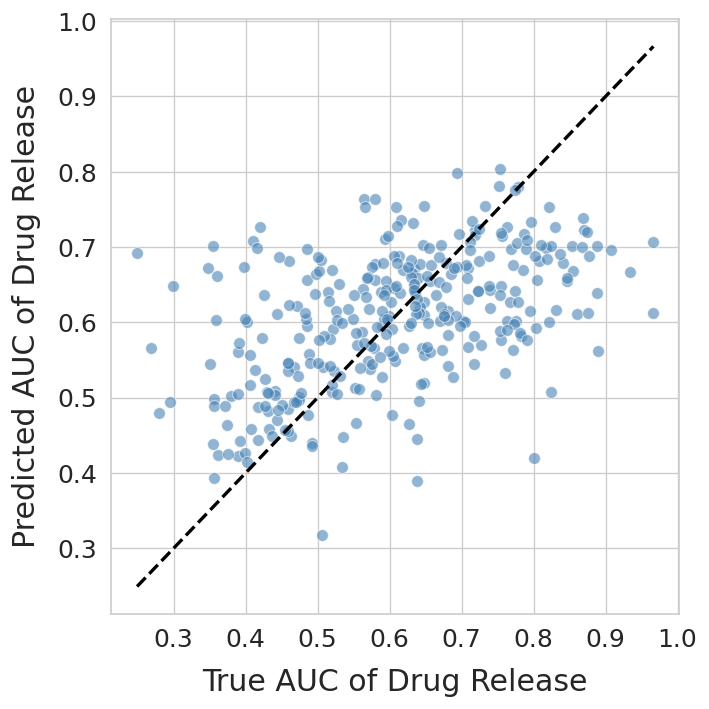

In [38]:
# Prepare combined arrays
all_true = np.concatenate(stored_test_targets)
all_pred = np.concatenate(stored_best_preds)

# --- Seaborn styling ---
sns.set_style("whitegrid")
sns.set_context("paper")   # "paper", "notebook", "talk", "poster"

plt.figure(figsize=(6, 6), dpi=120)

sns.scatterplot(
    x=all_true,
    y=all_pred,
    color="steelblue",  # choose any professional color
    alpha=0.6,
    edgecolor="white",
    s=50
)

# --- Perfect prediction line y=x ---
y_min, y_max = all_true.min(), all_true.max()
plt.plot([y_min, y_max], [y_min, y_max],
         linestyle="--", linewidth=2, color="black")

# --- Labels ---
plt.xlabel("True AUC of Drug Release", fontsize=18, labelpad=10)
plt.ylabel("Predicted AUC of Drug Release", fontsize=18, labelpad=10)

# --- Tick font sizes ---
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)



plt.tight_layout()
plt.show()
plt.close()    # closes it completely

## Visualization of Shapley additive explanations of feature importance

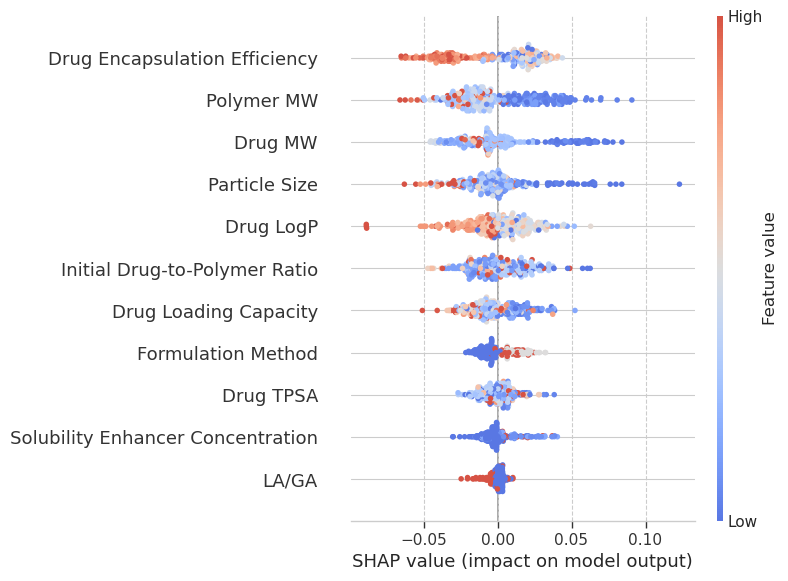

In [40]:
feature_names = ["Drug MW", "Drug TPSA", "Drug LogP", "Polymer MW",
                 "LA/GA","Initial Drug-to-Polymer Ratio", "Particle Size", "Drug Loading Capacity", "Drug Encapsulation Efficiency",
                 "Solubility Enhancer Concentration", "Formulation Method"]
# Combine stored values from all folds
combined_shap_values = np.concatenate(stored_shap_values, axis=0)
combined_X_test = np.concatenate(stored_shap_test_sets, axis=0)

# --- Create a lighter red-to-blue colormap ---
base_cmap = cm.get_cmap("coolwarm")  # red-to-blue
light_cmap = LinearSegmentedColormap.from_list(
    "light_coolwarm",
    base_cmap(np.linspace(0.1, 0.9, 256))  # cut off the darkest colors
)


plt.figure()
# SHAP summary plot with softened colors
shap.summary_plot(
    combined_shap_values,
    combined_X_test,
    feature_names=feature_names,
    plot_type="dot",
    cmap=light_cmap,
    show=False
#    alpha=0.9  # keep points mostly opaque, softer effect comes from colormap
)
# Get the current axes
ax = plt.gca()

# Add a clean, light grid
ax.grid(True, which='both', axis='x', linestyle='--')

# Optional: move grid behind points
ax.set_axisbelow(True)
plt.show()